# MODULE 4

Same task as Module 3, but using non-linear models

I know that the correct workflow is to calculate the Linear model before the non-linear. But as it was done in the previous module, I supress this part and start directly with Non-linear models

In [2]:
import time
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

pd.set_option('display.max_columns', None)
plt.style.use('fivethirtyeight')

In [3]:
path = '../Data/'

## Filtering data
❗❗ **IMPORTANT** ❗❗Only need to run if filtered DataFrame is not stored in <span style="color:green">'../Data/'</span>

In [25]:
df = pd.read_csv(path + 'feature_frame.csv')
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [ ]:
def filter_dataframe(df: pd.DataFrame, min_products: int=5):
    order_size = df.groupby('order_id')['outcome'].sum()
    filtered_orders = order_size[order_size>=5].index
    return df.loc[lambda x: x.order_id.isin(filtered_orders)]

df_feature = (
    df
    .pipe(filter_dataframe)
)

In [38]:
df_feature.groupby('order_id')['outcome'].sum().min()

np.float64(5.0)

In [40]:
df_feature.to_csv(path+'filtered_feature_frame.csv')

## Split data
A different approach than Module3 will be used. Now, I am going to calculate the cummulative sum of the orders along time and I will split by percentage of orders -> 0.6/0.2/0.2

In [4]:
df_feature = pd.read_csv(path + 'filtered_feature_frame.csv')
df_feature = (
    df_feature
    .assign(created_at = lambda x: pd.to_datetime(x.created_at))
    .assign(order_date = lambda x: pd.to_datetime(x.order_date))
)
df_feature.head()

,Unnamed: 0,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05,4,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [5]:
df_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2163953 entries, 0 to 2163952
Data columns (total 28 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   Unnamed: 0                        int64         
 1   variant_id                        int64         
 2   product_type                      object        
 3   order_id                          int64         
 4   user_id                           int64         
 5   created_at                        datetime64[ns]
 6   order_date                        datetime64[ns]
 7   user_order_seq                    int64         
 8   outcome                           float64       
 9   ordered_before                    float64       
 10  abandoned_before                  float64       
 11  active_snoozed                    float64       
 12  set_as_regular                    float64       
 13  normalised_price                  float64       
 14  discount_pct      

Train since 2020-10-05 00:00:00
Train until 2021-01-25 00:00:00
Val until 2021-02-14 00:00:00
Test until 2021-03-03 00:00:00


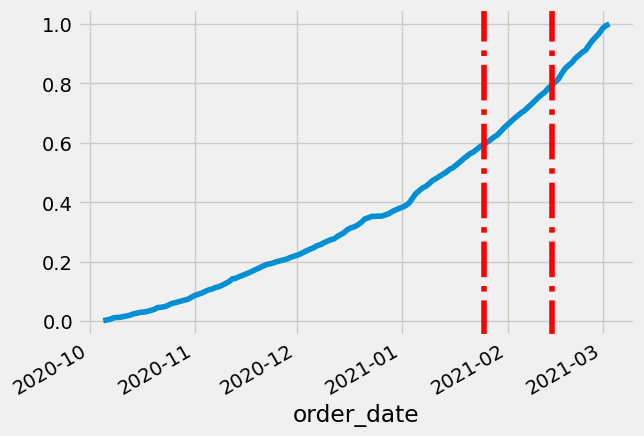

In [6]:
daily_orders = df_feature.groupby('order_date')['order_id'].nunique()
order_cumsum = daily_orders.cumsum() / daily_orders.sum()

train_thr   = order_cumsum[order_cumsum <= 0.6].idxmax()
val_thr     = order_cumsum[order_cumsum <= 0.8].idxmax()

print('Train since', order_cumsum.idxmin())
print('Train until', train_thr)
print('Val until', val_thr)
print('Test until', order_cumsum.idxmax() )

order_cumsum.plot(kind = 'line')
plt.axvline(x = train_thr, color='red', linestyle='-.')
plt.axvline(x = val_thr, color='red', linestyle='-.')

In [7]:
train_df    = df_feature[df_feature.order_date <= train_thr]
val_df      = df_feature[df_feature.order_date.between(train_thr, val_thr, inclusive = 'right')]
test_df     = df_feature[df_feature.order_date > val_thr]

assert train_df.order_date.isin(val_df.order_date).sum() == 0, 'train and val share some date'
assert train_df.order_date.isin(test_df.order_date).sum() == 0, 'train and test share some date'
assert val_df.order_date.isin(test_df.order_date).sum() == 0, 'test and val share some date'

In [ ]:
target_col = 'outcome'
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
cat_cols = ['product_type', 'vendor']
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
exclude_cols = ['days_since_purchase_variant_id', 'days_since_purchase_product_type']

feature_cols = [col for col in df_feature.columns if col not in info_cols + [target_col]]
numeric_cols = [col for col in feature_cols if col not in cat_cols + binary_cols]

In [9]:
def plot_metrics(
        model_name : str,
        y_pred : pd.Series,
        y_test : pd.Series,
        figure: tuple[matplotlib.figure.Figure, np.array] = None
):
    
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize = (14, 8))
    else:
        fig, ax = figure

    ax[0].plot(recall_, precision_, label = f'{model_name} -> AUC={pr_auc:.3f}')
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')
    ax[0].set_title(f'Precision-Recall Curve')
    ax[0].legend()

    ax[1].plot(fpr, tpr, label = f'{model_name} -> AUC={roc_auc:.3f}')
    ax[1].set_xlabel('FPR')
    ax[1].set_ylabel('TPR')
    ax[1].set_title(f'ROC Curve')
    ax[1].legend()



## Baseline model

We are considering that our model is behaving linearly with respect to the variable 'global_popularity'

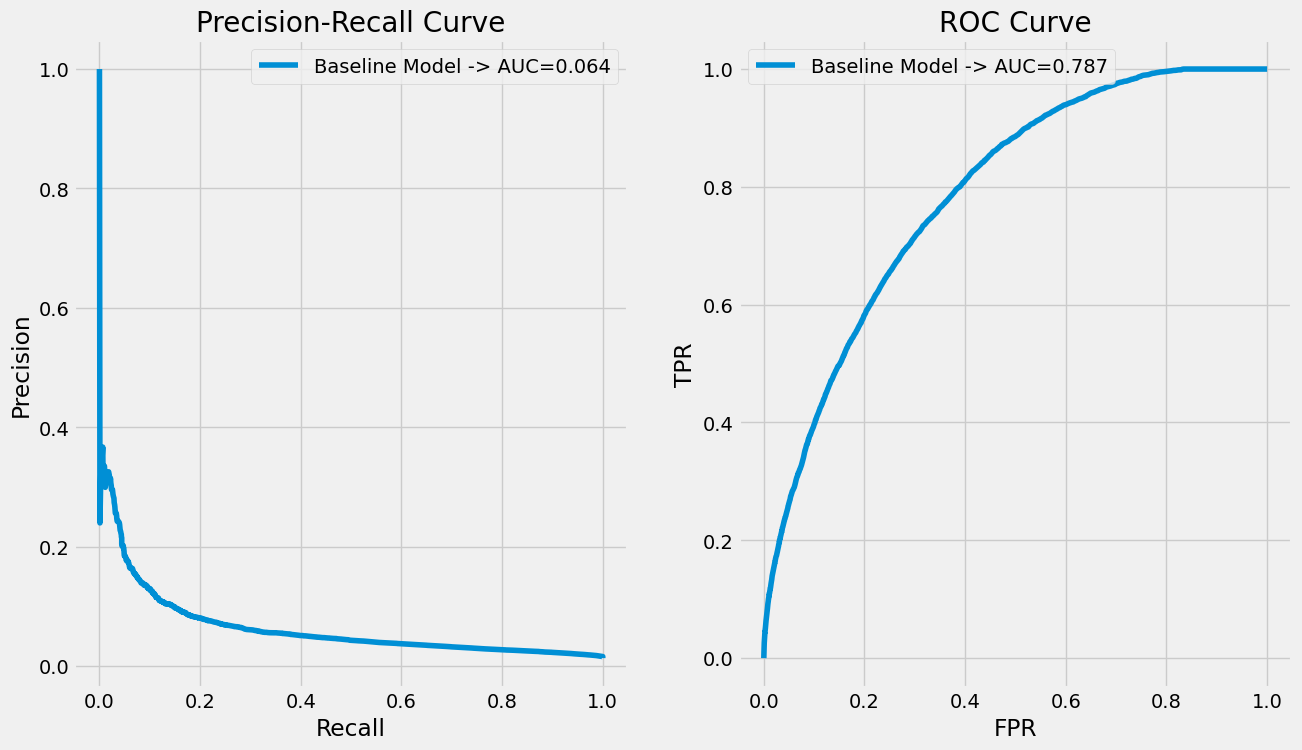

In [10]:
plot_metrics('Baseline Model', y_pred = val_df['global_popularity'], y_test = val_df['outcome'])

## Model Training

In [11]:
X_train, y_train = train_df.drop(target_col, axis=1), train_df[target_col]
X_val, y_val = val_df.drop(target_col, axis=1), val_df[target_col]
X_test, y_test = test_df.drop(target_col, axis=1), test_df[target_col]

In [12]:
train_cols = numeric_cols + binary_cols

### RANDOM FOREST

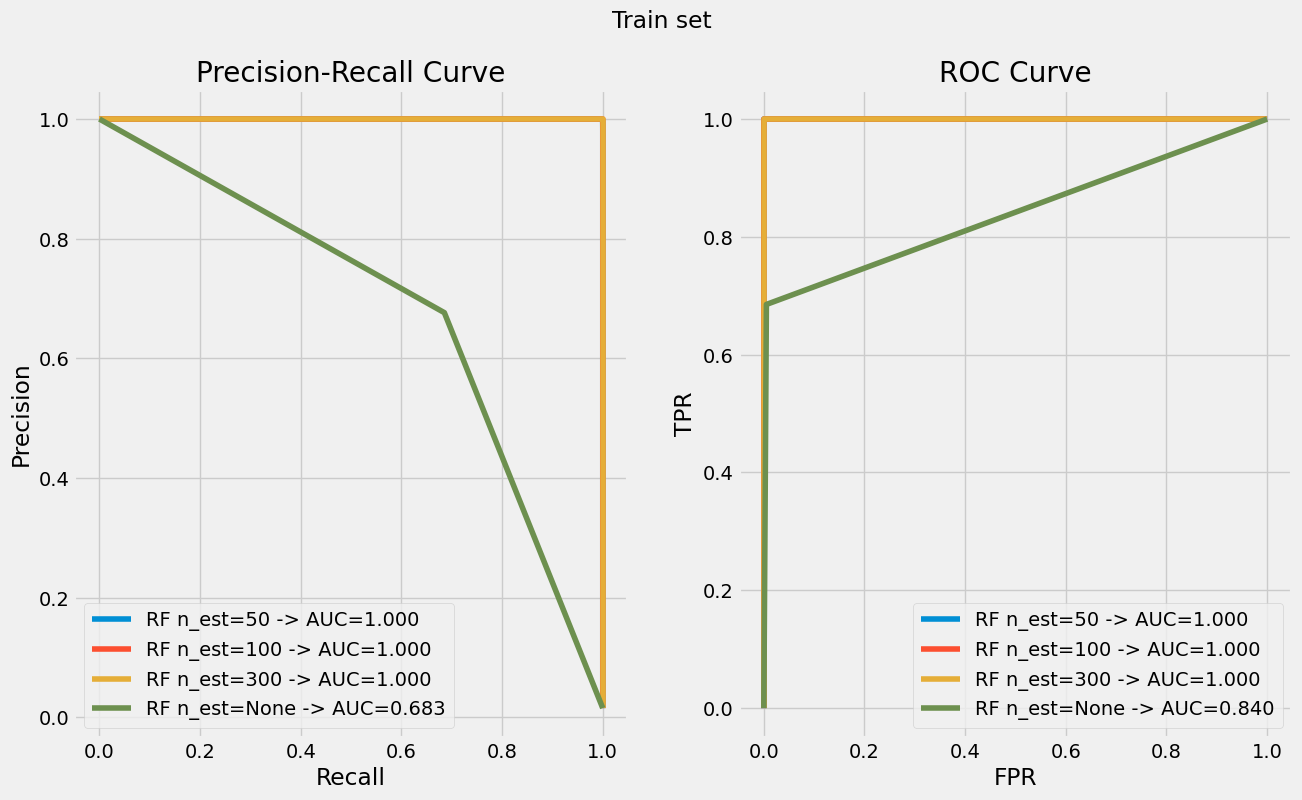

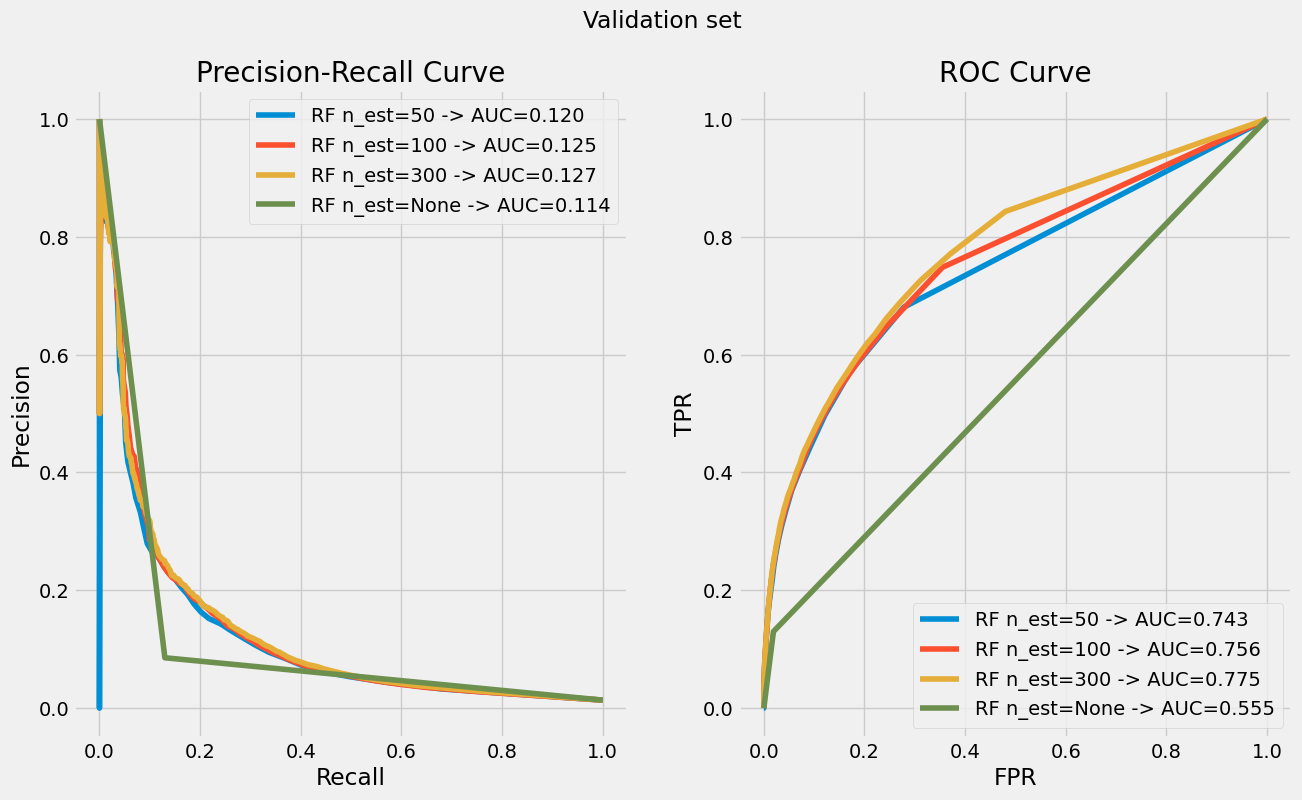

In [61]:
fig1, ax1 = plt.subplots(1, 2, figsize = (14, 8))
fig1.suptitle('Train set')

fig2, ax2 = plt.subplots(1, 2, figsize = (14, 8))
fig2.suptitle('Validation set')

est = [50, 100, 300, None]

for e in est:
    RF1 = make_pipeline(
        StandardScaler(),
        RandomForestClassifier(n_estimators=e if e is not None else 1)
    )

    RF1.fit(X_train[train_cols], y_train)

    train_proba = RF1.predict_proba(X_train[train_cols])[:,1]
    val_proba   = RF1.predict_proba(X_val[train_cols])[:,1]

    plot_metrics(f'RF n_est={e}', y_pred = train_proba, y_test = y_train, figure=(fig1, ax1))
    plot_metrics(f'RF n_est={e}', y_pred = val_proba, y_test = y_val, figure=(fig2, ax2))





- Results for higher numbers of estimators clearly show an overfitting trend on the training data.
- PR curve seems better for higher number of estimators. However the computation time for 300 estimators was pretty high, so for the little improvement achieved does not compensate the time wasted.


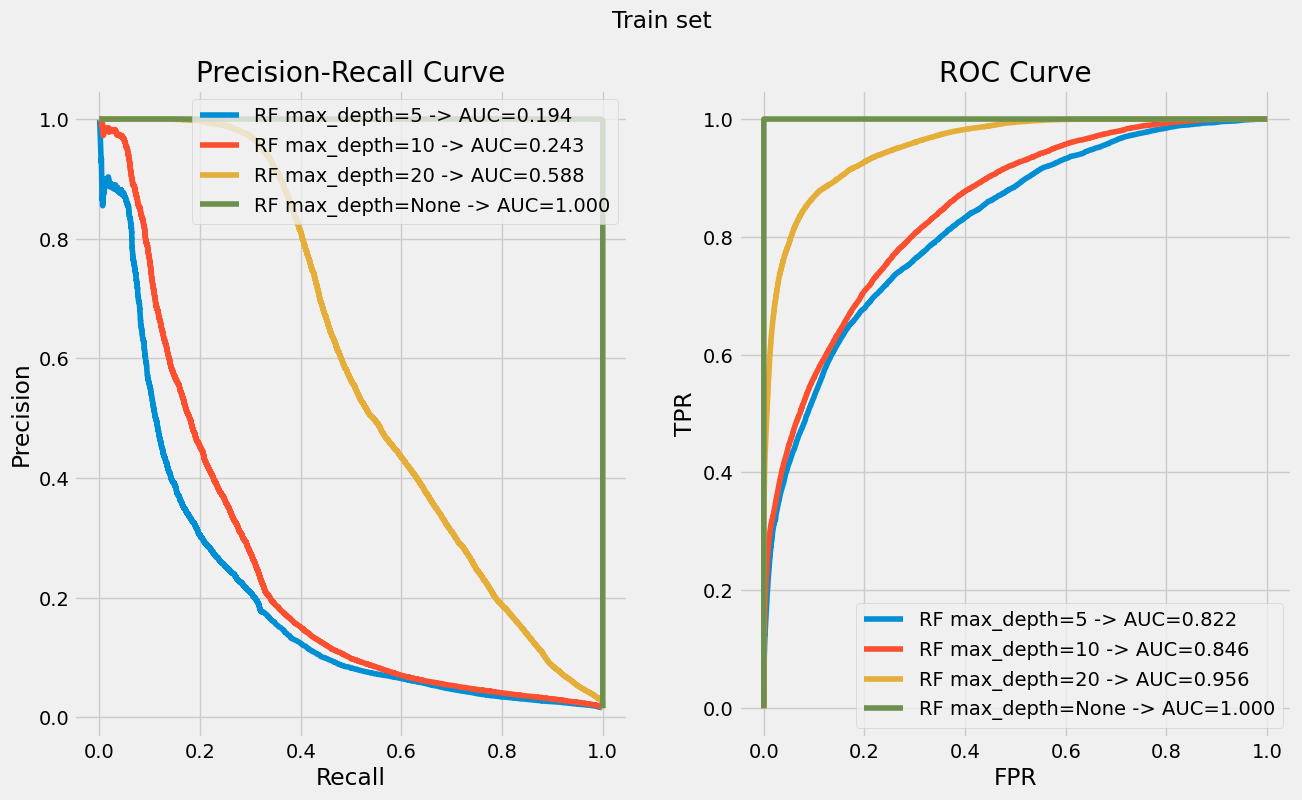

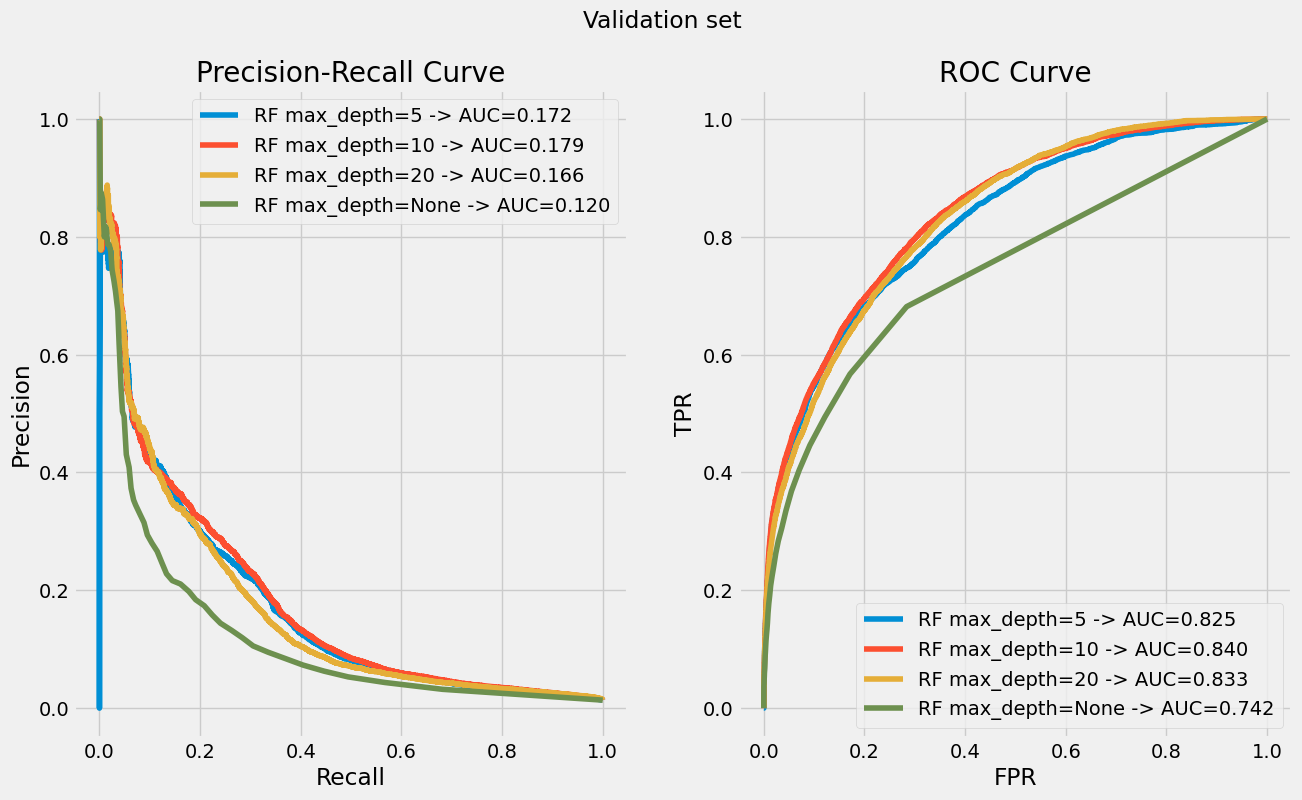

In [60]:
fig3, ax3 = plt.subplots(1, 2, figsize = (14, 8))
fig3.suptitle('Train set')

fig4, ax4 = plt.subplots(1, 2, figsize = (14, 8))
fig4.suptitle('Validation set')

max_depth = [5, 10, 20, None]

for md in max_depth:
    RF2 = make_pipeline(
        StandardScaler(), 
        RandomForestClassifier(n_estimators=50, max_depth = md)
    )

    RF2.fit(X_train[train_cols], y_train)
    train_proba = RF2.predict_proba(X_train[train_cols])[:,1]
    val_proba   = RF2.predict_proba(X_val[train_cols])[:,1]

    plot_metrics(f'RF max_depth={md}', y_pred = train_proba, y_test = y_train, figure = (fig3, ax3))
    plot_metrics(f'RF max_depth={md}', y_pred = val_proba, y_test = y_val, figure = (fig4, ax4))

- The values for train and test are similar for certain values of *max_depth*, which could indicate that the model is not overfitting. However, for *None* it seems to overfit.
- A *max_depth* of 10 seems to have the better predictive behavior.

### Gradient Boosting Trees

Total time carried by n_estimators = 50 is 115.25536279997323
Total time carried by n_estimators = 100 is 251.64676450006664
Total time carried by n_estimators = 250 is 561.6692929000128
Total time carried by n_estimators = None is 15.405268100090325


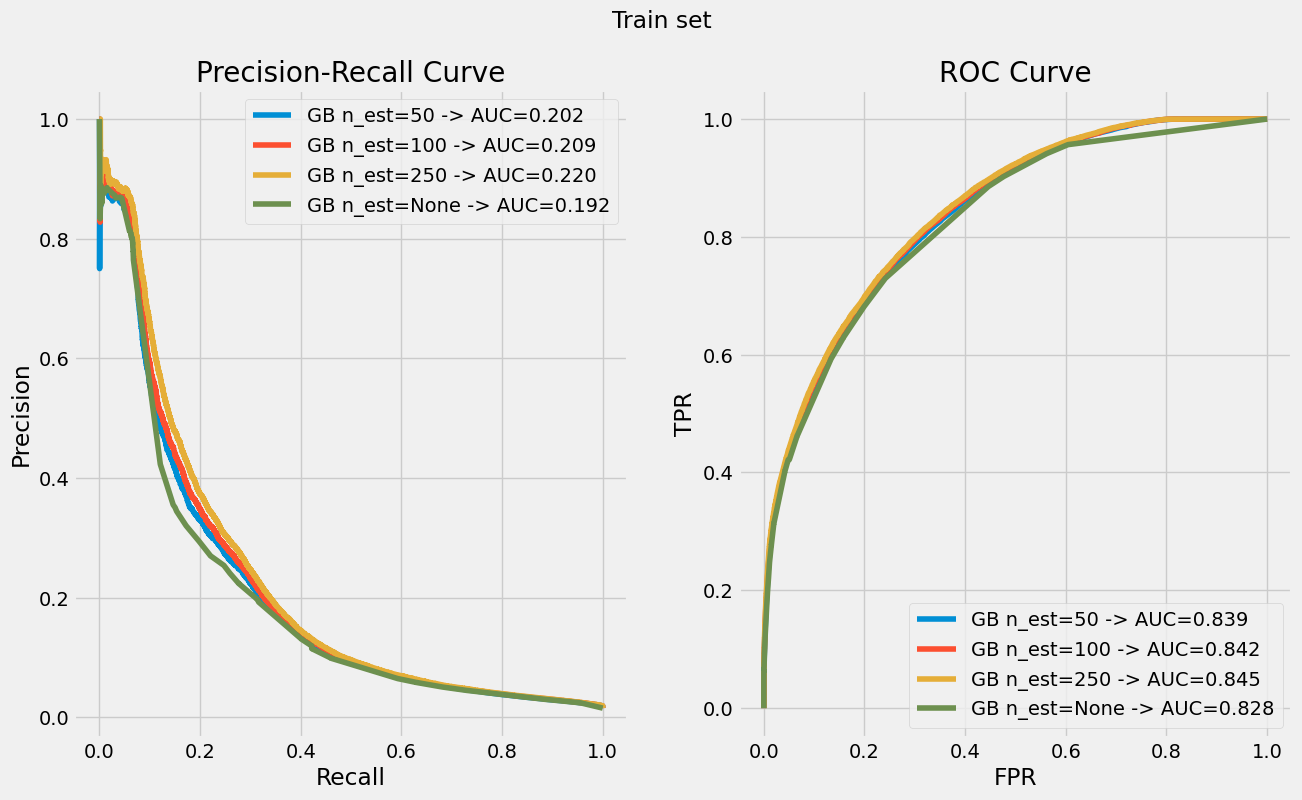

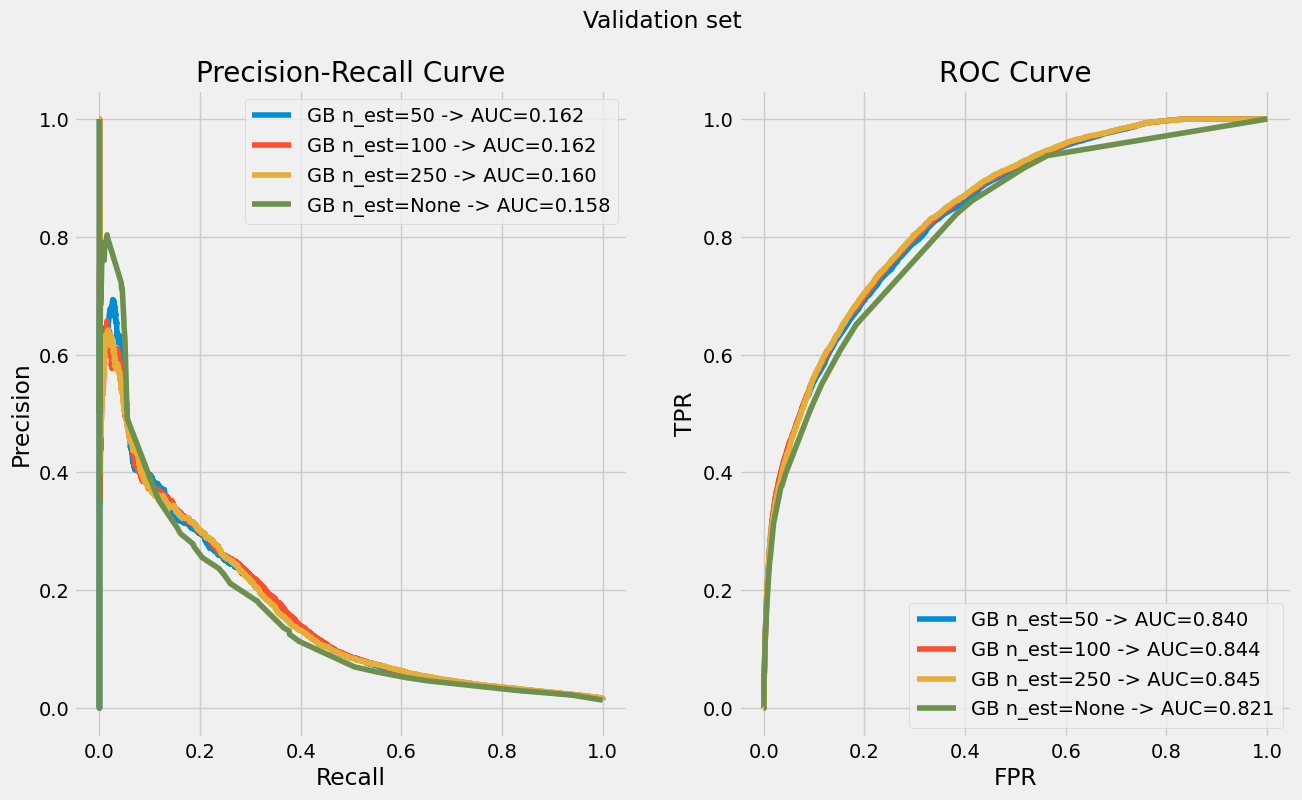

In [14]:
fig1, ax1 = plt.subplots(1, 2, figsize = (14, 8))
fig1.suptitle('Train set')

fig2, ax2 = plt.subplots(1, 2, figsize = (14, 8))
fig2.suptitle('Validation set')

n_estimator = [50, 100, 250, None]

for n in n_estimator:
    t0 = time.perf_counter()
    GB = make_pipeline(
        StandardScaler(), 
        GradientBoostingClassifier(n_estimators=n if n is not None else 5)
    )

    GB.fit(X_train[train_cols], y_train)

    train_proba = GB.predict_proba(X_train[train_cols])[:,1]
    val_proba = GB.predict_proba(X_val[train_cols])[:,1]

    plot_metrics(f'GB n_est={n}', y_pred = train_proba, y_test = y_train, figure=(fig1, ax1))
    plot_metrics(f'GB n_est={n}', y_pred = val_proba, y_test = y_val, figure=(fig2, ax2))
    t1 = time.perf_counter()

    print(f'Total time carried by n_estimators = {n} is {t1-t0}')

- Gradient boosting shows a better behavior at first for lower n_estimators in the P-R curve. But this is due to a peak in the firt part of the curve (which is more unstable and is not usually considered). For the rest of the curve, they behave quite similar, leading to keep the lower # of estimators to save computational time.
- In the ROC curve, the better result is for the higher number of estimators, but just for a little, not supposing a determinant factor for choosing this model.
- For base cases (not changing anything apart from number of trees) we get that Gradient Boosting is way better than random forest. But if we limit the random forest´s depth, we get better results. Anyway, this would be increasing variance and decreasing bias, which could give another results for different datasets.
- It has been decided that the best model is for n_estimators = 100

## MODEL TRAINING WITH CATEGORICAL VARIABLES

In [20]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import clone

encoders = [
    ('on_hot', OneHotEncoder(handle_unknown='ignore')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
]

### RandomForest
Try with a max_depth of 10 and 200 estimators with different encoding methods

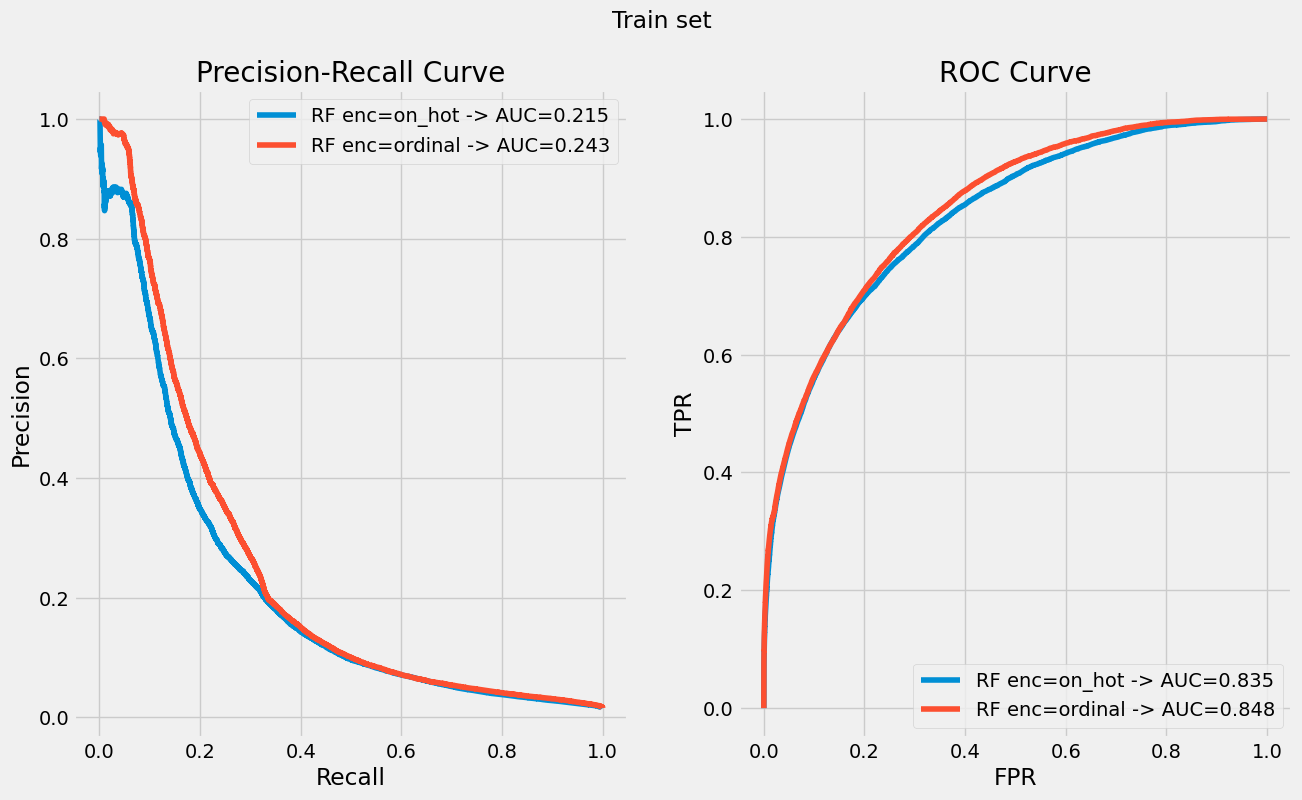

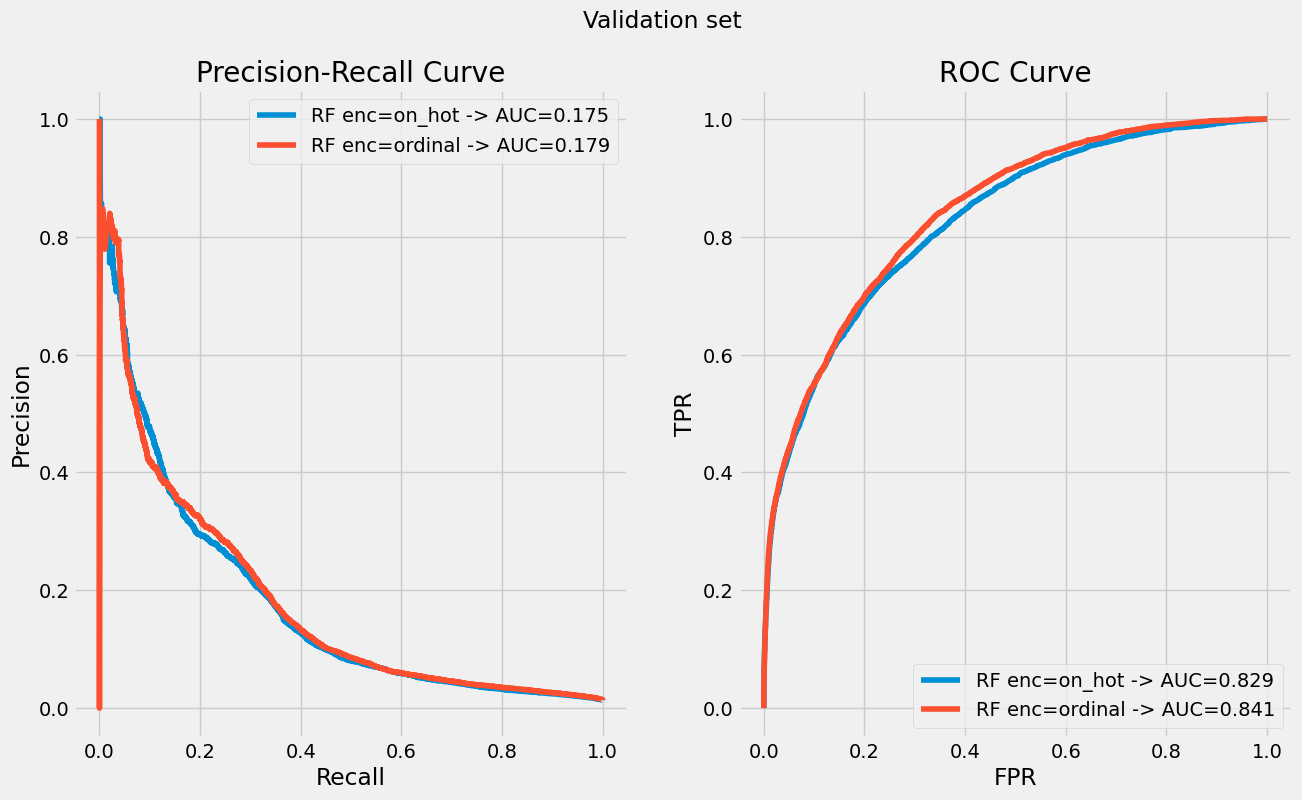

In [22]:
fig1, ax1 = plt.subplots(1, 2, figsize = (14, 8))
fig1.suptitle('Train set')

fig2, ax2 = plt.subplots(1, 2, figsize = (14, 8))
fig2.suptitle('Validation set')

train_cols_cat = train_cols + cat_cols

for name, cat_encoder in encoders:
    enc = clone(cat_encoder)
    preprocessor = ColumnTransformer(
        [
        ('numerical', 'passthrough', train_cols),
        ('categorical', cat_encoder, cat_cols)
        ],
        remainder='drop',
        sparse_threshold=0.0
    )

    RF = make_pipeline(
        preprocessor,
        StandardScaler(),
        RandomForestClassifier(n_estimators = 50, max_depth=10)
    )

    RF.fit(X_train[train_cols_cat], y_train)

    train_proba = RF.predict_proba(X_train)[:,1]
    val_proba = RF.predict_proba(X_val[train_cols_cat])[:,1]

    plot_metrics(f'RF enc={name}', y_pred = train_proba, y_test = y_train, figure = (fig1, ax1))
    plot_metrics(f'RF enc={name}', y_pred = val_proba, y_test = y_val, figure = (fig2, ax2))

- RF with ordinal encoding, max_depth = 10 and n_estimators = 50 shows the same behavior in terms of auc for both PR curve and ROC curve in validation set than the case without categorical variables (pr_auc = 0.179 and roc_auc = 0.84)
- For saving computational time, encoding can be ommitted.

In [ ]:
fig1, ax1 = plt.subplots(1, 2, figsize = (14, 8))
fig1.suptitle('Train set')

fig2, ax2 = plt.subplots(1, 2, figsize = (14, 8))
fig2.suptitle('Validation set')

train_cols_cat = train_cols + cat_cols

for name, cat_encoder in encoders:
    enc = clone(cat_encoder)
    preprocessor = ColumnTransformer(
        [
        ('numerical', 'passthrough', train_cols),
        ('categorical', cat_encoder, cat_cols)
        ],
        remainder='drop',
        sparse_threshold=0.0
    )

    GB = make_pipeline(
        preprocessor,
        StandardScaler(),
        GradientBoostingClassifier()
    )

    GB.fit(X_train[train_cols_cat], y_train)

    train_proba = GB.predict_proba(X_train)[:,1]
    val_proba = GB.predict_proba(X_val[train_cols_cat])[:,1]

    plot_metrics(f'RF enc={name}', y_pred = train_proba, y_test = y_train, figure = (fig1, ax1))
    plot_metrics(f'RF enc={name}', y_pred = val_proba, y_test = y_val, figure = (fig2, ax2))